In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import struct
from keras.layers import Conv2D
from keras.layers import Input
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from keras.layers import ZeroPadding2D
from keras.layers import UpSampling2D
from tensorflow.keras.layers import add, concatenate
from keras.models import Model

# Residual Networks(ResNets)

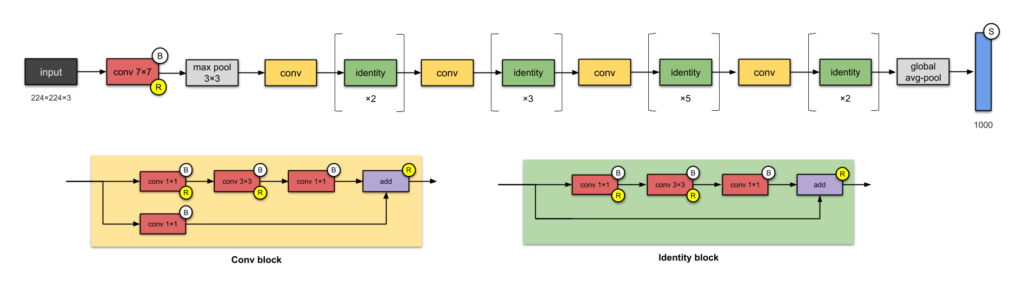

# Convolutional Block & Identity Block

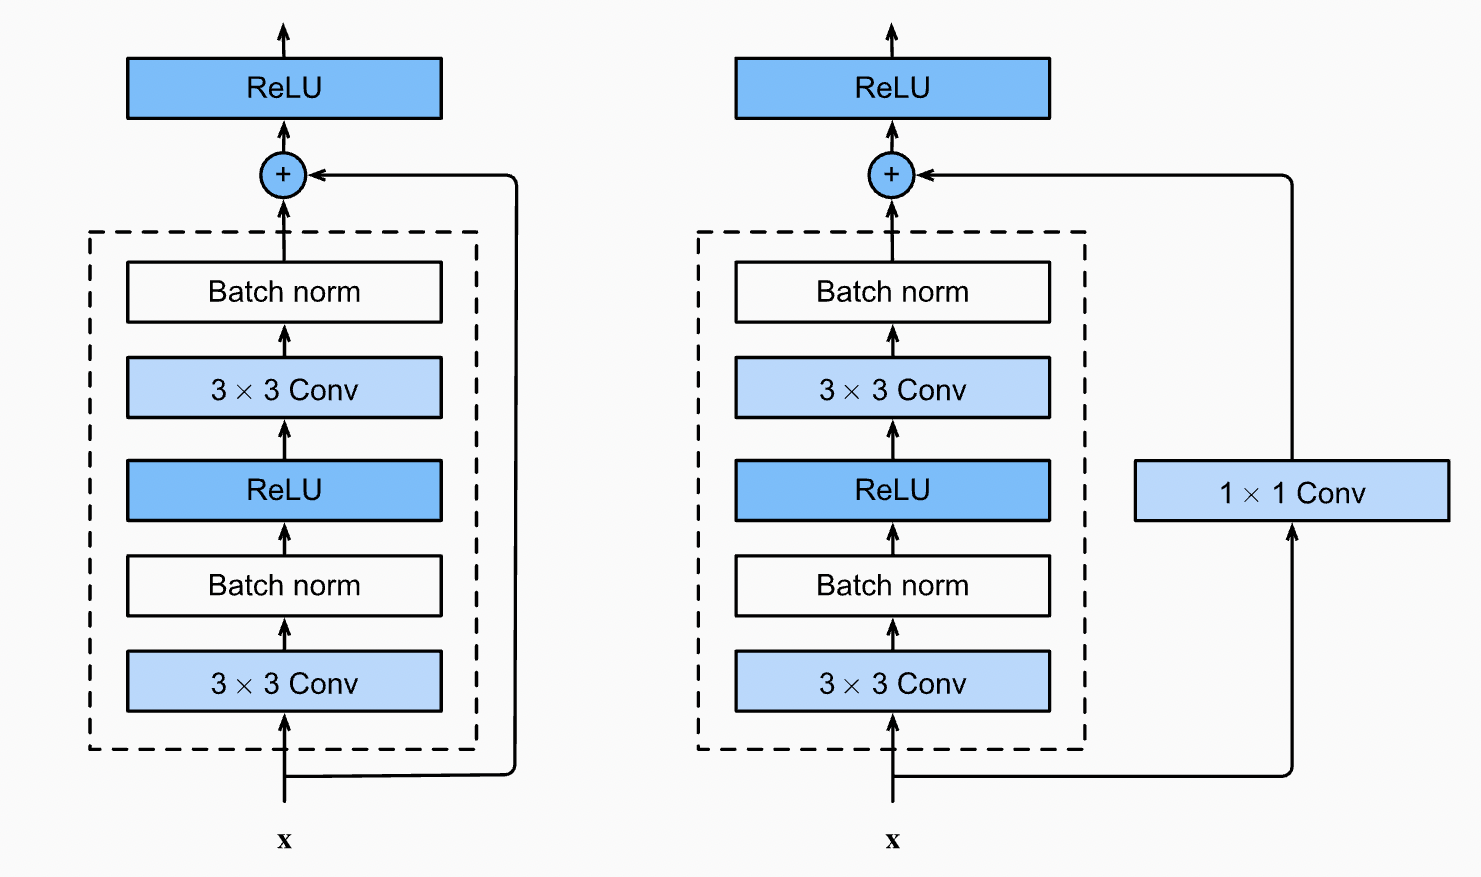

### 1.The identity block —
__same as the one we saw above. The identity block is the standard block used in ResNets and corresponds to the case where the input activation has the same dimension as the output activation.__

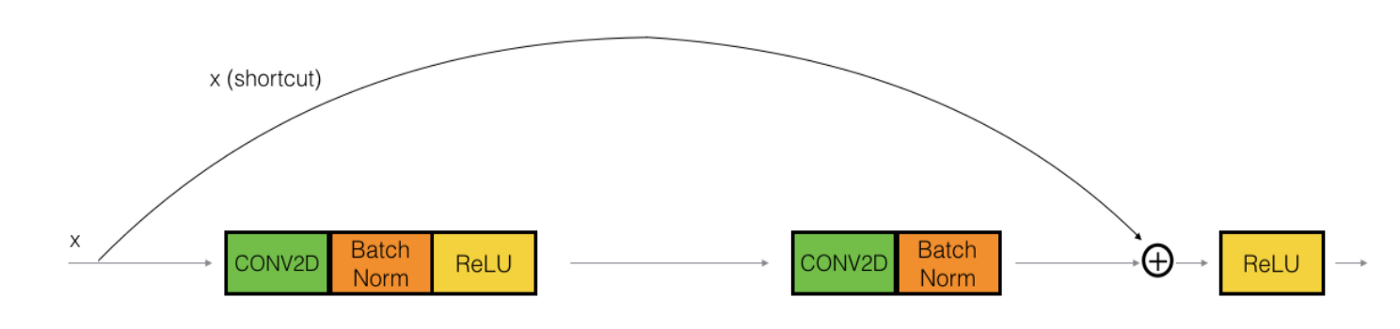

### 2. The Convolutional block — 
__We can use this type of block when the input and output dimensions don’t match up. The difference with the identity block is that there is a CONV2D layer in the shortcut path.__

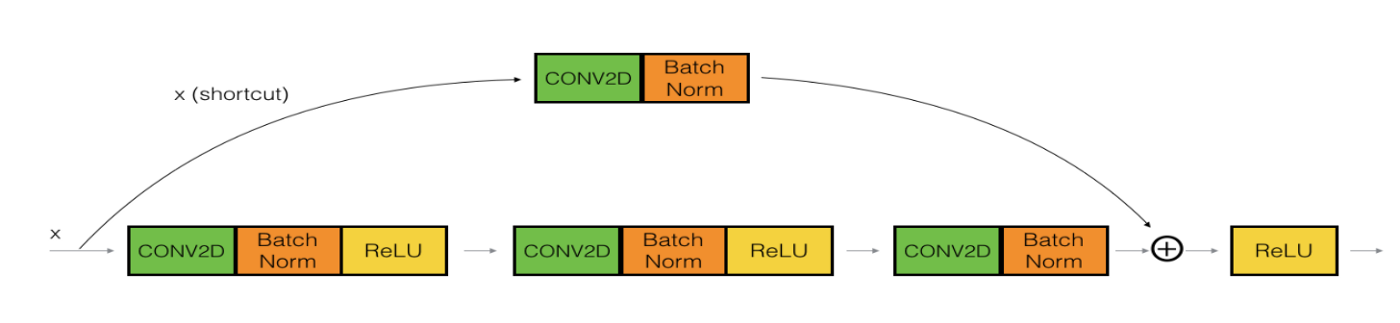

## ResNet Arch.

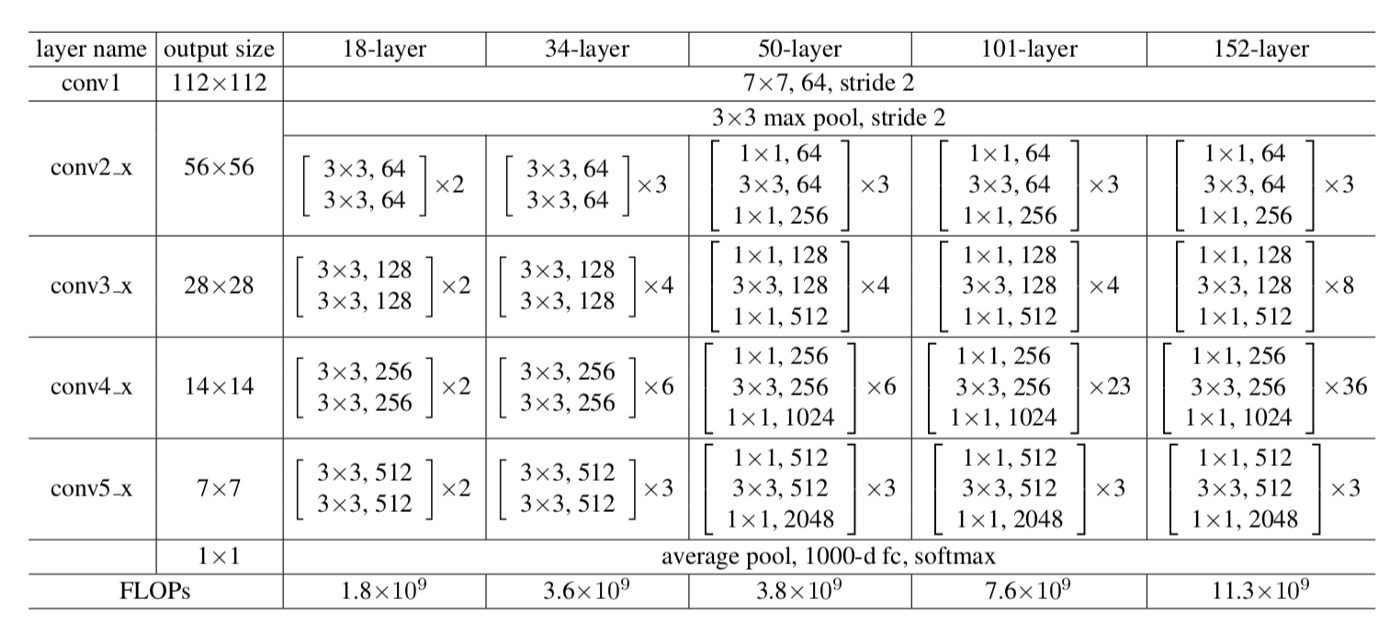

In [13]:
def _conv_block(inp, convs, skip = True):
    x = inp
    count = 0
    for conv in convs:
        if count == (len(convs) - 2)and skip:
            skip_connection = x
        count = count + 1
        if conv["strides"] > 1: x = ZeroPadding2D(((1,0),(1,0))) (x)
            
        x = Conv2D(conv['filter'],
                   conv['kernel'],
                   strides = conv["strides"],
                   padding = "valid" if conv['strides']>1 else 'same',
                   name = 'conv_'+str(conv["layer_idx"]),
                   use_bias = False if conv['bnorm']else True)(x)
        if conv['bnorm']: x = BatchNormalization(epsilon=0.001, name='bnorm_' + str(conv['layer_idx']))(x)
        if conv['leaky']: x = LeakyReLU(alpha=0.1, name='leaky_' + str(conv['layer_idx']))(x)
    return add([skip_connection, x]) if skip else x
                  

def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    

    # Second component of main path 
    X = Conv2D(F2, (f,f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer=glorot_uniform(seed =0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu') (X)

## YOLO ARCHITECTURE

In [26]:
# import image module
from IPython.display import Image
  
# get the image
Image(url="https://appsilon.com/_gatsby/image/963008c37c14f91bf9b4a0bf56ef937b/6d30c11a32152d612aae5ec8d139993b/8-4.avif?u=https%3A%2F%2Fwordpress.appsilon.com%2Fwp-content%2Fuploads%2F2020%2F05%2F8-4.png&a=w%3D1920%26h%3D1530%26fm%3Davif%26q%3D90&cd=2022-04-20T08%3A25%3A44", width=700, height=700)

## Understanding YOLO object detection: the YOLO algorithm
To understand the YOLO algorithm, it is necessary to establish what is actually being predicted. Ultimately, we aim to predict a class of an object and the bounding box specifying object location. Each bounding box can be described using four descriptors:

center of a bounding box (bxby)
width (bw)
height (bh)
value cis corresponding to a class of an object (e.g., car, traffic lights, etc.)
To learn more about PP-YOLO (or PaddlePaddle YOLO), which is an improvement on YOLOv4, read our explanation of why PP-YOLO is faster than YOLOv4.

In addition, we have to predict the pc value, which is the probability that there is an object in the bounding box.

In [24]:
Image(url="https://appsilon.com/_gatsby/image/84f3d79d25711ea9b06ae6495e63247c/23cfb99afb401f79e635c4669fd7f499/7-5.avif?u=https%3A%2F%2Fwordpress.appsilon.com%2Fwp-content%2Fuploads%2F2020%2F05%2F7-5.png&a=w%3D990%26h%3D1376%26fm%3Davif%26q%3D90&cd=2022-04-20T08%3A24%3A42", width=900, height=600)

As we mentioned above, when working with the YOLO algorithm we are not searching for interesting regions in our image that could potentially contain an object.

Instead, we are splitting our image into cells, typically using a 19×19 grid. Each cell is responsible for predicting 5 bounding boxes (in case there is more than one object in this cell). Therefore, we arrive at a large number of 1805 bounding boxes for one image. Rather than seizing the day with #YOLO and Carpe Diem, we’re looking to seize object probability. The exchange of accuracy for more speed isn’t reckless behavior, but a necessary requirement for faster real-time object detection.

### Special Thanks to <https://appsilon.com/object-detection-yolo-algorithm/>

### YOLO Model Building

In [17]:
def make_yolov3_model():
    input_image = Input(shape=(None, None, 3))
    
    # Layer  0 => 4
    x = _conv_block(input_image, [{'filter': 32, 'kernel': 3, 'strides': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 0},
                                  {'filter': 64, 'kernel': 3, 'strides': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 1},
                                  {'filter': 32, 'kernel': 1, 'strides': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 2},
                                  {'filter': 64, 'kernel': 3, 'strides': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 3}])
    
    # Layer  5 => 8
    x = _conv_block(x, [{'filter': 128, 'kernel': 3, 'strides': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 5},
                        {'filter':  64, 'kernel': 1, 'strides': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 6},
                        {'filter': 128, 'kernel': 3, 'strides': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 7}])
    
    # Layer  9 => 1s1
    x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'strides': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 9},
                        {'filter': 128, 'kernel': 3, 'strides': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 10}])
    
    # Layer 12 => 15
    x = _conv_block(x, [{'filter': 256, 'kernel': 3, 'strides': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 12},
                        {'filter': 128, 'kernel': 1, 'strides': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 13},
                        {'filter': 256, 'kernel': 3, 'strides': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 14}])
    
    # Layer 16 => 36
    for i in range(7):
        x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'strides': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 16+i*3},
                            {'filter': 256, 'kernel': 3, 'strides': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 17+i*3}])
    skip_36 = x
    
    # Layer 37 => 40
    x = _conv_block(x, [{'filter': 512, 'kernel': 3, 'strides': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 37},
                        {'filter': 256, 'kernel': 1, 'strides': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 38},
                        {'filter': 512, 'kernel': 3, 'strides': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 39}])
    
    # Layer 41 => 61
    for i in range(7):
        x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'strides': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 41+i*3},
                            {'filter': 512, 'kernel': 3, 'strides': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 42+i*3}])
    skip_61 = x
    
    # Layer 62 => 65
    x = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'strides': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 62},
                        {'filter':  512, 'kernel': 1, 'strides': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 63},
                        {'filter': 1024, 'kernel': 3, 'strides': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 64}])
    
    # Layer 66 => 74
    for i in range(3):
        x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'strides': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 66+i*3},
                            {'filter': 1024, 'kernel': 3, 'strides': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 67+i*3}])
    
    # Layer 75 => 79
    x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'strides': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 75},
                        {'filter': 1024, 'kernel': 3, 'strides': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 76},
                        {'filter':  512, 'kernel': 1, 'strides': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 77},
                        {'filter': 1024, 'kernel': 3, 'strides': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 78},
                        {'filter':  512, 'kernel': 1, 'strides': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 79}], skip=False)
    
    # Layer 80 => 82
    yolo_82 = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'strides': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 80},
                              {'filter':  255, 'kernel': 1, 'strides': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 81}], skip=False)
    
    # Layer 83 => 86
    x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'strides': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 84}], skip=False)
    x = UpSampling2D(2)(x)
    x = concatenate([x, skip_61])
    
    # Layer 87 => 91
    x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'strides': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 87},
                        {'filter': 512, 'kernel': 3, 'strides': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 88},
                        {'filter': 256, 'kernel': 1, 'strides': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 89},
                        {'filter': 512, 'kernel': 3, 'strides': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 90},
                        {'filter': 256, 'kernel': 1, 'strides': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 91}], skip=False)
    
    # Layer 92 => 94
    yolo_94 = _conv_block(x, [{'filter': 512, 'kernel': 3, 'strides': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 92},
                              {'filter': 255, 'kernel': 1, 'strides': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 93}], skip=False)
   
    # Layer 95 => 98
    x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'strides': 1, 'bnorm': True, 'leaky': True,   'layer_idx': 96}], skip=False)
    x = UpSampling2D(2)(x)
    x = concatenate([x, skip_36])
    
    # Layer 99 => 106
    yolo_106 = _conv_block(x, [{'filter': 128, 'kernel': 1, 'strides': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 99},
                               {'filter': 256, 'kernel': 3, 'strides': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 100},
                               {'filter': 128, 'kernel': 1, 'strides': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 101},
                               {'filter': 256, 'kernel': 3, 'strides': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 102},
                               {'filter': 128, 'kernel': 1, 'strides': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 103},
                               {'filter': 256, 'kernel': 3, 'strides': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 104},
                               {'filter': 255, 'kernel': 1, 'strides': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 105}], skip=False)
    model = Model(input_image, [yolo_82, yolo_94, yolo_106])
    return model

In [18]:
class WeightReader:
    def __init__(self, weight_file):
        with open(weight_file, 'rb') as w_f:
            major,	= struct.unpack('i', w_f.read(4))
            minor,	= struct.unpack('i', w_f.read(4))
            revision, = struct.unpack('i', w_f.read(4))
            if (major*10 + minor) >= 2 and major < 1000 and minor < 1000:
                w_f.read(8)
            else:
                w_f.read(4)
            transpose = (major > 1000) or (minor > 1000)
            binary = w_f.read()
        self.offset = 0
        self.all_weights = np.frombuffer(binary, dtype='float32')
    def read_bytes(self, size):
        self.offset = self.offset + size
        return self.all_weights[self.offset-size:self.offset]
    def load_weights(self, model):
        for i in range(106):
            try:
                conv_layer = model.get_layer('conv_' + str(i))
                print("loading weights of convolution #" + str(i))
                if i not in [81, 93, 105]:
                    norm_layer = model.get_layer('bnorm_' + str(i))
                    size = np.prod(norm_layer.get_weights()[0].shape)
                    beta  = self.read_bytes(size) # bias
                    gamma = self.read_bytes(size) # scale
                    mean  = self.read_bytes(size) # mean
                    var   = self.read_bytes(size) # variance
                    weights = norm_layer.set_weights([gamma, beta, mean, var])
                if len(conv_layer.get_weights()) > 1:
                    bias   = self.read_bytes(np.prod(conv_layer.get_weights()[1].shape))
                    kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
                    kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
                    kernel = kernel.transpose([2,3,1,0])
                    conv_layer.set_weights([kernel, bias])
                else:
                    kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
                    kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
                    kernel = kernel.transpose([2,3,1,0])
                    conv_layer.set_weights([kernel])
            except ValueError:
                print("no convolution #" + str(i))
    def reset(self):
        self.offset = 0

In [19]:
model = make_yolov3_model()

In [20]:
weight_reader = WeightReader('yolov3.weights')

In [21]:
weight_reader.load_weights(model)

loading weights of convolution #0
loading weights of convolution #1
loading weights of convolution #2
loading weights of convolution #3
no convolution #4
loading weights of convolution #5
loading weights of convolution #6
loading weights of convolution #7
no convolution #8
loading weights of convolution #9
loading weights of convolution #10
no convolution #11
loading weights of convolution #12
loading weights of convolution #13
loading weights of convolution #14
no convolution #15
loading weights of convolution #16
loading weights of convolution #17
no convolution #18
loading weights of convolution #19
loading weights of convolution #20
no convolution #21
loading weights of convolution #22
loading weights of convolution #23
no convolution #24
loading weights of convolution #25
loading weights of convolution #26
no convolution #27
loading weights of convolution #28
loading weights of convolution #29
no convolution #30
loading weights of convolution #31
loading weights of convolution #32

In [22]:
model.save('model.h5')